# 다변량 정규분포를 이용한 재현자료 척도 비교 

# 패키지 , 데이터 불러오기

In [41]:
import os
import pickle 
import sdv.metrics
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/HANBatang.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 평가척도를 위한 패키지 불러오기

In [43]:
from sdmetrics.single_column import KSComplement
from sdmetrics.column_pairs import CorrelationSimilarity
from sdmetrics.single_column import RangeCoverage
from sdmetrics.single_column import StatisticSimilarity
from sdmetrics.single_column import BoundaryAdherence
from sdmetrics.single_column import CSTest
from sdmetrics.single_table import NewRowSynthesis
from sdv.metadata import SingleTableMetadata # 싱글 메타 데이터의 경우에만! 멀티 메타 데이터의 경우에는 패키지를 다르게 불러와야함
from sdmetrics.reports.single_table import QualityReport 
from sdmetrics.reports.single_table import DiagnosticReport
from sdv.evaluation.single_table import evaluate_quality # Use this function to evaluate the quality of your synthetic data in terms of column shapes and correlations.
from sdv.evaluation.single_table import run_diagnostic # Check to see if the synthetic rows are pure copies of the real data
from sdv.evaluation.single_table import get_column_plot # Use this function to visualize a real column against the same synthetic column

# 서버에서 돌린 데이터 불러오기

In [44]:
path = "D:/Simulation Data/2023-09-10"

In [45]:
os.chdir(path)

In [46]:
dir_list = os.listdir(path)

In [47]:
print(dir_list)

['all_rho1_mvn.pkl', 'all_rho2_mvn.pkl', 'all_rho3_mvn.pkl', 'all_rho4_mvn.pkl', 'all_rho5_mvn.pkl', 'non_rho1_mvn.pkl', 'non_rho2_mvn.pkl', 'non_rho3_mvn.pkl', 'non_rho4_mvn.pkl', 'non_rho5_mvn.pkl', 'ori_all_rho1_data.pkl', 'ori_all_rho2_data.pkl', 'ori_all_rho3_data.pkl', 'ori_all_rho4_data.pkl', 'ori_all_rho5_data.pkl', 'ori_non_rho1_data.pkl', 'ori_non_rho2_data.pkl', 'ori_non_rho3_data.pkl', 'ori_non_rho4_data.pkl', 'ori_non_rho5_data.pkl']


In [48]:
def load_pickle(file_name) : 
    with open(file_name , 'rb') as f:
        return pickle.load(f)

### 경상소득(포함) 다변량 정규분포 불러오기

In [49]:
all_rho1_mvn = load_pickle(dir_list[0])
all_rho2_mvn = load_pickle(dir_list[1])
all_rho3_mvn = load_pickle(dir_list[2])
all_rho4_mvn = load_pickle(dir_list[3])
all_rho5_mvn = load_pickle(dir_list[4])

### 경상소득(미포함) 다변량 정규분포 불러오기

In [50]:
non_rho1_mvn = load_pickle(dir_list[5])
non_rho2_mvn = load_pickle(dir_list[6])
non_rho3_mvn = load_pickle(dir_list[7])
non_rho4_mvn = load_pickle(dir_list[8])
non_rho5_mvn = load_pickle(dir_list[9])

In [51]:
path = "D:/Simulation Data/2023-09-14"
os.chdir(path)
dir_list = os.listdir(path)

In [52]:
dir_list

['GC_all_rho1_data.pkl',
 'GC_all_rho2_data.pkl',
 'GC_all_rho3_data.pkl',
 'GC_all_rho4_data.pkl',
 'GC_all_rho5_data.pkl',
 'GC_non_rho1_data.pkl',
 'GC_non_rho2_data.pkl',
 'GC_non_rho3_data.pkl',
 'GC_non_rho4_data.pkl',
 'GC_non_rho5_data.pkl']

### 경상소득(포함) 다변량 정규분포의 재현자료 불러오기

In [53]:
GC_all_rho1_data = load_pickle(dir_list[0])
GC_all_rho2_data = load_pickle(dir_list[1])
GC_all_rho3_data = load_pickle(dir_list[2])
GC_all_rho4_data = load_pickle(dir_list[3])
GC_all_rho5_data = load_pickle(dir_list[4])

### 경상소득(미포함) 다변량 정규분포 재현자료 불러오기

In [54]:
GC_non_rho1_data = load_pickle(dir_list[5])
GC_non_rho2_data = load_pickle(dir_list[6])
GC_non_rho3_data = load_pickle(dir_list[7])
GC_non_rho4_data = load_pickle(dir_list[8])
GC_non_rho5_data = load_pickle(dir_list[9])

### 미포함 자료에 대한 경상소득(조사) 열 만들기

In [55]:
def sum_income(data) : 
    
    for i in range(500):
        data[i]['경상소득(조사)'] = data[i].iloc[:,1:6].sum(axis = 1)
        

In [56]:
sum_income(non_rho1_mvn)
sum_income(non_rho2_mvn)
sum_income(non_rho3_mvn)
sum_income(non_rho4_mvn)
sum_income(non_rho5_mvn)

In [57]:
sum_income(GC_non_rho1_data)
sum_income(GC_non_rho2_data)
sum_income(GC_non_rho3_data)
sum_income(GC_non_rho4_data)
sum_income(GC_non_rho5_data)

## 편차 구해주고 평균 , 표준편차 구해주고 데이터프레임으로 만들어주는 함수

In [58]:
def unbiased(variable , synthetic_data , mvn_data , iteration):
    
    mean = np.array([synthetic_data[i][variable].mean() - mvn_data[i][variable].mean() for i in range(500)])
    std  = np.array([synthetic_data[i][variable].std() - mvn_data[i][variable].std() for i in range(500)])  
    qu25 = np.array([np.quantile(synthetic_data[i][variable] , q = .25) - np.quantile(mvn_data[i][variable] , q = .25) for i in range(iteration)])
    qu50 = np.array([np.quantile(synthetic_data[i][variable] , q = .50) - np.quantile(mvn_data[i][variable] , q = .50) for i in range(iteration)])
    qu75 = np.array([np.quantile(synthetic_data[i][variable] , q = .75) - np.quantile(mvn_data[i][variable] , q = .75) for i in range(iteration)])
    qu90 = np.array([np.quantile(synthetic_data[i][variable] , q = .90) - np.quantile(mvn_data[i][variable] , q = .90) for i in range(iteration)])
    qu99 = np.array([np.quantile(synthetic_data[i][variable] , q = .99) - np.quantile(mvn_data[i][variable] , q = .99) for i in range(iteration)])    
    result = np.array([[mean.mean() , mean.std()] , [std.mean() , std.std()] , [qu25.mean() , qu25.std()] , [qu50.mean() , qu50.std()] , [qu75.mean() , qu75.std()] , [qu90.mean() , qu90.std()] , [qu99.mean() , qu99.std()]])
    frame = pd.DataFrame(result)
    frame.columns = ["Bia의 평균" , "Bias의 표준편차"]
    frame.index = ['평균' , '표준편차' , '25%' , '50%' , '75%' , '90%' , '99%']
    return pd.DataFrame(frame )



### 경상소득(조사) 포함 안된 것에 대한 데이터프레임

In [59]:
a1 = unbiased('경상소득(조사)' , GC_non_rho1_data , non_rho1_mvn , 500)
a2 = unbiased('경상소득(조사)' , GC_non_rho2_data , non_rho2_mvn , 500)
a3 = unbiased('경상소득(조사)' , GC_non_rho3_data , non_rho3_mvn , 500)
a4 = unbiased('경상소득(조사)' , GC_non_rho4_data , non_rho4_mvn , 500)
a5 = unbiased('경상소득(조사)' , GC_non_rho5_data , non_rho5_mvn , 500)

In [60]:
pd.concat([a1,a2,a3,a4,a5] , axis = 1)

Bia의 평균  Bias의 표준편차    Bia의 평균  Bias의 표준편차   Bia의 평균  Bias의 표준편차  \
평균    -2.264706   37.833660   2.040896   46.790516  3.032756   52.991620   
표준편차  -1.077514   27.376654   0.276298   32.249515 -2.240560   36.121821   
25%   -5.077563   62.480546  -1.924270   74.180990  4.416231   81.386361   
50%    0.000125   57.205997   3.646922   71.305975  7.010338   79.574277   
75%   -1.240921   64.123509   6.266288   71.337506  4.719714   81.944616   
90%   -1.196775   76.533219  11.827606   94.529733  0.764978  105.700584   
99%  -23.402539  194.847113 -15.386549  230.756353  6.429335  255.056269   

       Bia의 평균  Bias의 표준편차    Bia의 평균  Bias의 표준편차  
평균   -0.081150   58.193523  -2.370160   60.262787  
표준편차  0.787708   42.823361   0.449331   48.461198  
25%  -0.130467   89.865357  -3.871493   99.404286  
50%   1.393287   81.965405   3.415218   92.293715  
75%   0.431342   93.792264  -2.347567  103.521279  
90%   8.362155  117.895418   5.120725  122.802712  
99%  -5.008666  280.191954  18.374909  299.383024

### 경상소득(조사) 포함 된 것에 대한 데이터프레임

In [61]:
b1 = unbiased('경상소득(조사)' , GC_all_rho1_data , all_rho1_mvn , 500)
b2 = unbiased('경상소득(조사)' , GC_all_rho2_data , all_rho2_mvn , 500)
b3 = unbiased('경상소득(조사)' , GC_all_rho3_data , all_rho3_mvn , 500)
b4 = unbiased('경상소득(조사)' , GC_all_rho4_data , all_rho4_mvn , 500)
b5 = unbiased('경상소득(조사)' , GC_all_rho5_data , all_rho5_mvn , 500)

In [62]:
pd.concat([b1,b2,b3,b4,b5] , axis = 1)

Bia의 평균  Bias의 표준편차   Bia의 평균  Bias의 표준편차   Bia의 평균  Bias의 표준편차  \
평균    2.023710   32.447502 -1.084343   32.107837 -0.574731   34.296790   
표준편차  0.324308   24.471829  1.874368   23.616107  0.245188   24.268090   
25%   1.985293   54.593663 -6.708200   52.103146 -0.131821   53.247743   
50%   2.831355   48.802649 -1.323074   46.921178  1.797942   50.117976   
75%   4.055808   51.414185  4.353307   52.906066  1.837090   53.050318   
90%   8.317662   63.738697  3.829564   67.768759 -0.092095   67.723331   
99%  -4.774938  160.001935 -5.595163  153.456965  3.943433  164.845338   

       Bia의 평균  Bias의 표준편차   Bia의 평균  Bias의 표준편차  
평균    0.530001   33.297848 -0.015619   32.590971  
표준편차 -0.864373   23.661673 -0.509612   24.134768  
25%  -0.200798   49.928993 -2.571972   49.203139  
50%   2.745730   49.584024 -1.816992   47.094668  
75%   2.314162   54.560403  2.265310   55.348174  
90%  -0.178920   65.504700  4.341141   61.537184  
99%   0.229653  161.334717  4.726359  159.385083

## 상자그림 한꺼번에 보여주는 함수 (평균 ,표준편차 , 25% , 50% , 75% , 90% , 99%)

In [63]:
def all_boxplot(variable, statistic, iteration):
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    data_to_plot = []
    
    for i in range(1, 6):
        original = eval(f'all_rho{i}_mvn')
        synthetic = eval(f'GC_all_rho{i}_data') 
        
        if statistic == 'mean':
            a = [np.mean(original[j][variable]) for j in range(iteration)]
            b = [np.mean(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == 'std':
            a = [np.std(original[j][variable]) for j in range(iteration)]
            b = [np.std(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == '25%':
            a = [np.quantile(original[j][variable] , q = .25) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable] , q = .25) for j in range(iteration)]
        elif statistic == '50%':
            a = [np.quantile(original[j][variable] , q = .50) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .50) for j in range(iteration)]
        elif statistic == '75%':
            a = [np.quantile(original[j][variable], q = .75) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .75) for j in range(iteration)]
        elif statistic == '90%':
            a = [np.quantile(original[j][variable], q = .90) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .90) for j in range(iteration)]
        elif statistic == '99%':
            a = [np.quantile(original[j][variable], q = .99) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .99) for j in range(iteration)]        
        else:
            raise ValueError("no invalid statistic")

        data_to_plot.append(a)
        data_to_plot.append(b)
        
    ax.boxplot(data_to_plot, labels=['A', 'B'] * 5)
    ax.set_xlabel('Data Type')
    ax.set_ylabel('Value')
    plt.title(statistic.capitalize())  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

In [64]:
def non_all_boxplot(variable, statistic, iteration):
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    data_to_plot = []
    
    for i in range(1, 6):
        original = eval(f'non_rho{i}_mvn')
        synthetic = eval(f'GC_non_rho{i}_data') 
        
        if statistic == 'mean':
            a = [np.mean(original[j][variable]) for j in range(iteration)]
            b = [np.mean(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == 'std':
            a = [np.std(original[j][variable]) for j in range(iteration)]
            b = [np.std(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == '25%':
            a = [np.quantile(original[j][variable] , q = .25) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable] , q = .25) for j in range(iteration)]
        elif statistic == '50%':
            a = [np.quantile(original[j][variable] , q = .50) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .50) for j in range(iteration)]
        elif statistic == '75%':
            a = [np.quantile(original[j][variable], q = .75) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .75) for j in range(iteration)]
        elif statistic == '90%':
            a = [np.quantile(original[j][variable], q = .90) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .90) for j in range(iteration)]
        elif statistic == '99%':
            a = [np.quantile(original[j][variable], q = .99) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .99) for j in range(iteration)]        
        else:
            raise ValueError("no invalid statistic")

        data_to_plot.append(a)
        data_to_plot.append(b)
        
    ax.boxplot(data_to_plot, labels=['A', 'B'] * 5)
    ax.set_xlabel('Data Type')
    ax.set_ylabel('Value')
    plt.title(statistic.capitalize())  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

### 평균에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

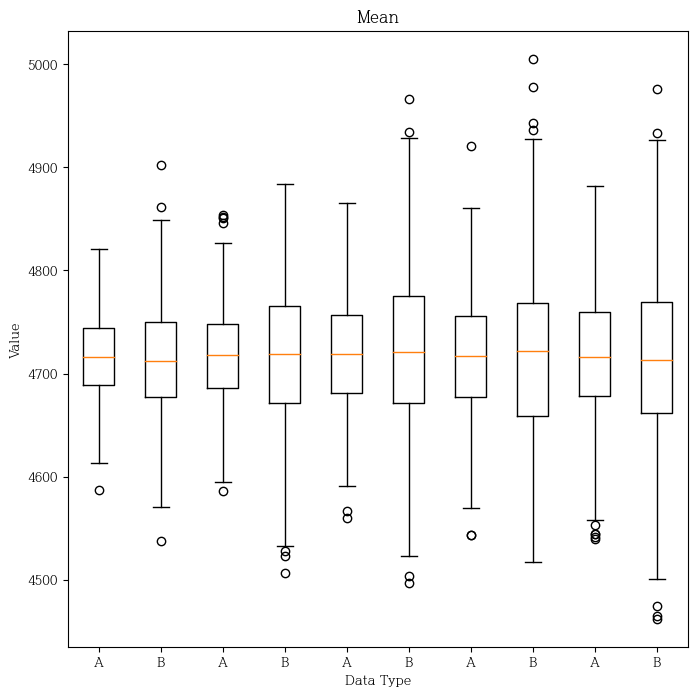

In [29]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = 'mean' , iteration = 500)

### 평균에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

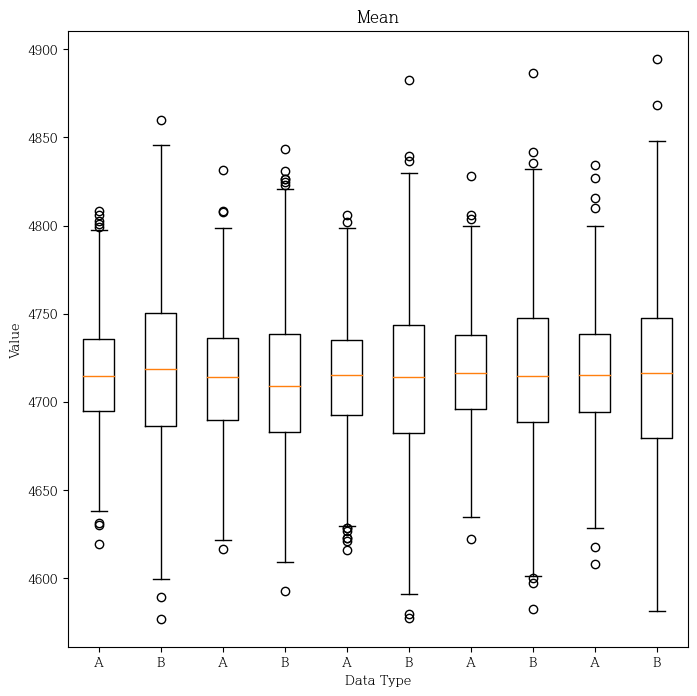

In [65]:
all_boxplot(variable = "경상소득(조사)" , statistic = 'mean' , iteration = 500)

### 표준편차에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

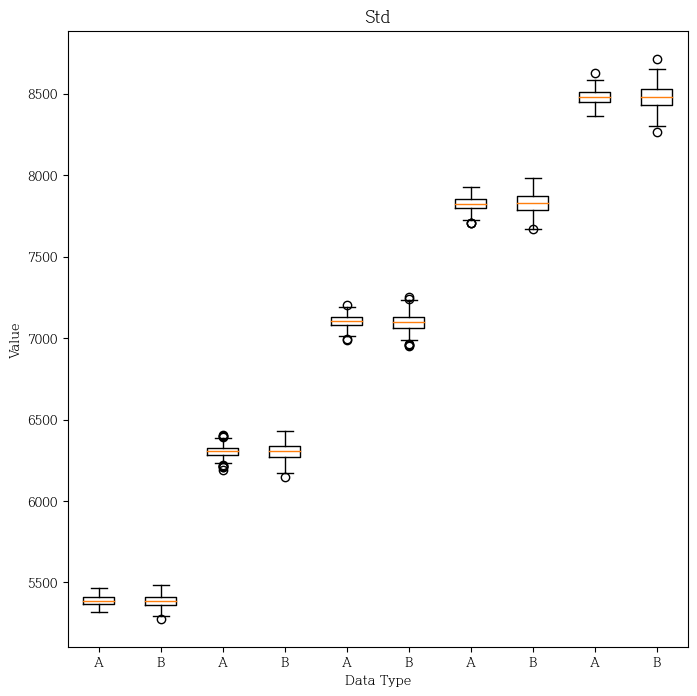

In [32]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = 'std' , iteration = 500)

### 표준편차에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

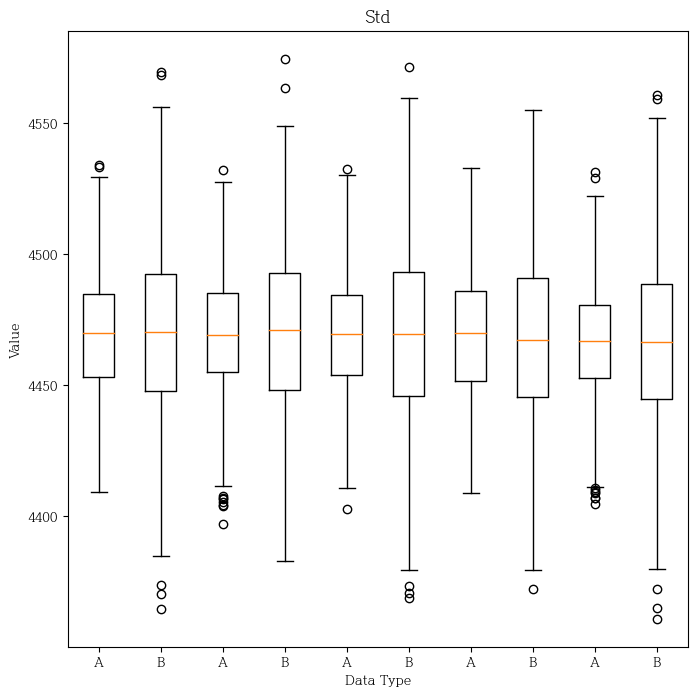

In [66]:
all_boxplot(variable = "경상소득(조사)" , statistic = 'std' , iteration = 500)

### 25% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

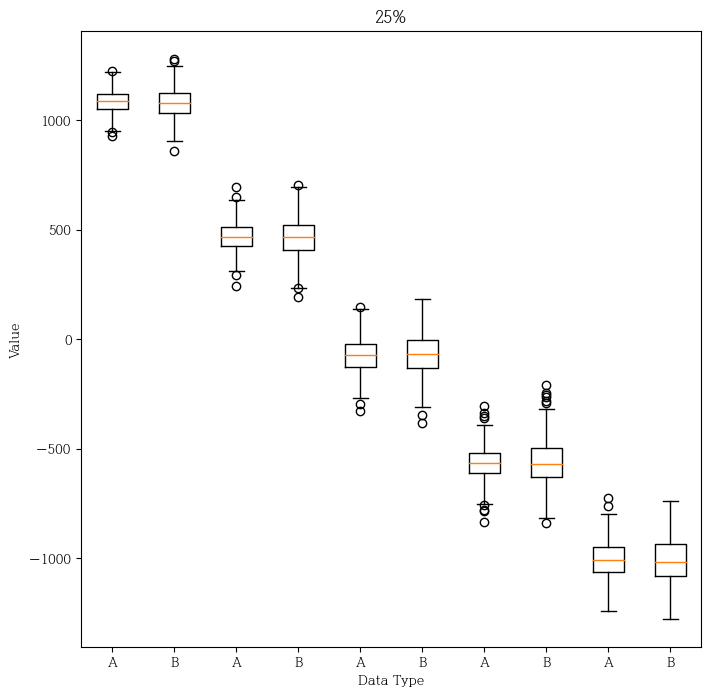

In [34]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '25%' , iteration = 500)

### 25% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

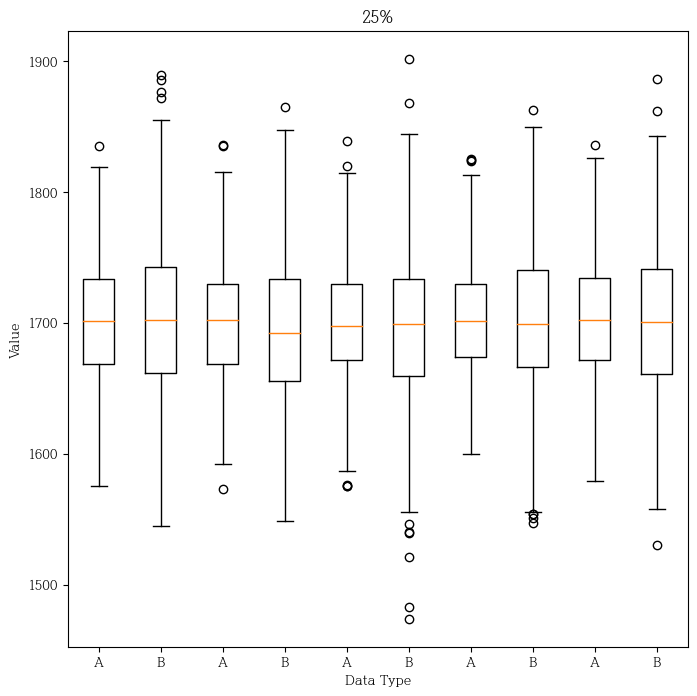

In [67]:
all_boxplot(variable = "경상소득(조사)" , statistic = '25%' , iteration = 500)

### 50% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

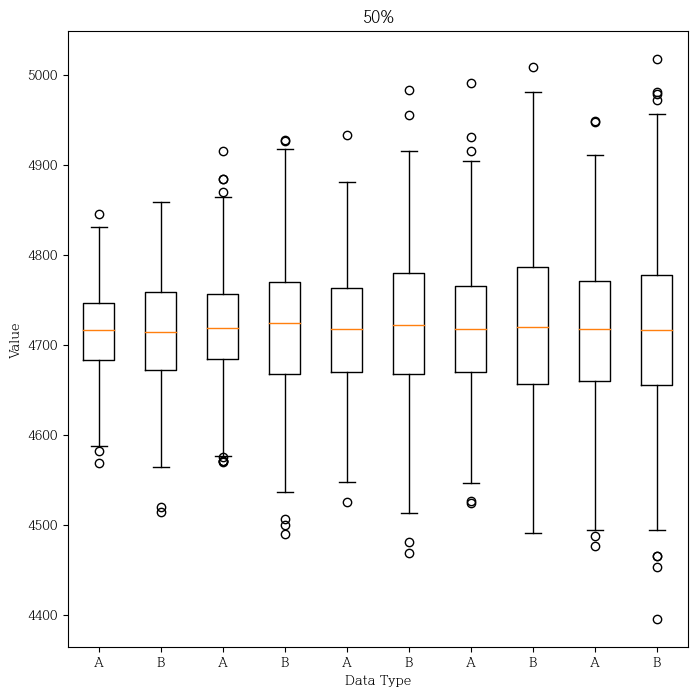

In [36]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '50%' , iteration = 500)

### 50% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

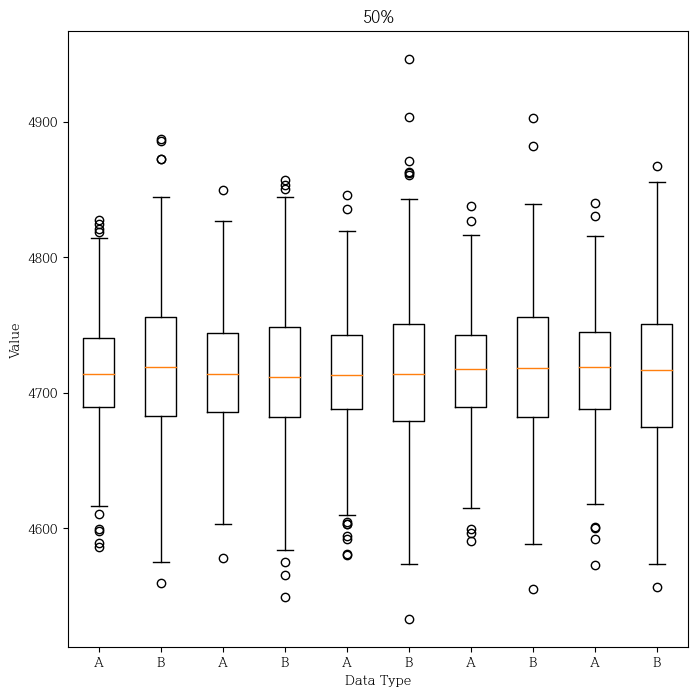

In [68]:
all_boxplot(variable = "경상소득(조사)" , statistic = '50%' , iteration = 500)

### 75% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

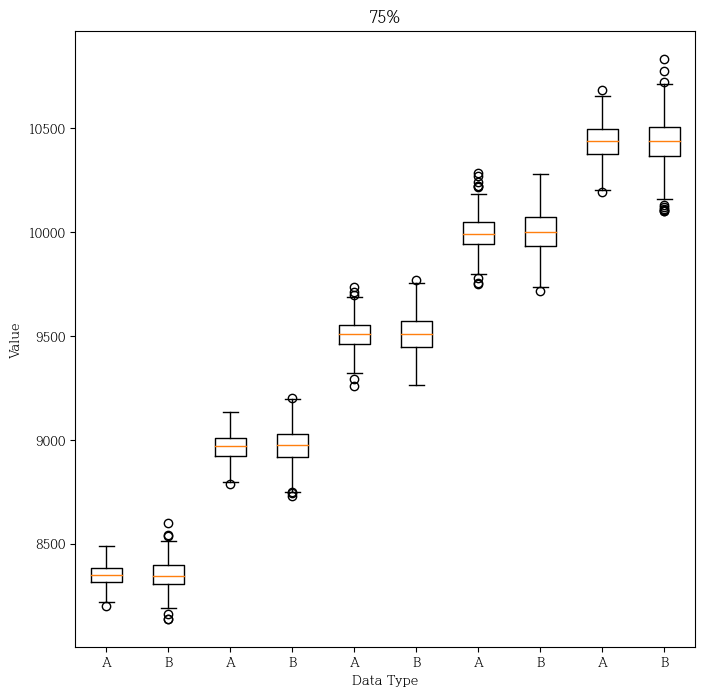

In [38]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '75%' , iteration = 500)

### 75% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

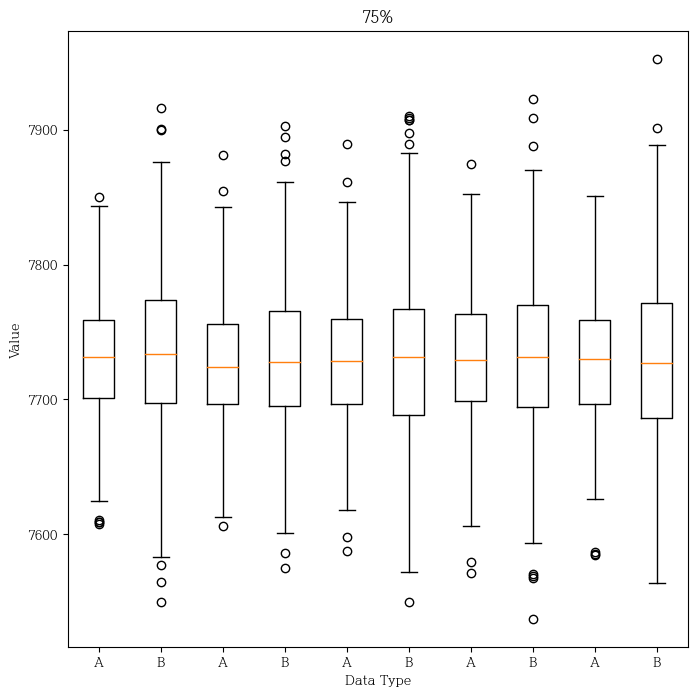

In [69]:
all_boxplot(variable = "경상소득(조사)" , statistic = '75%' , iteration = 500)

### 90% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

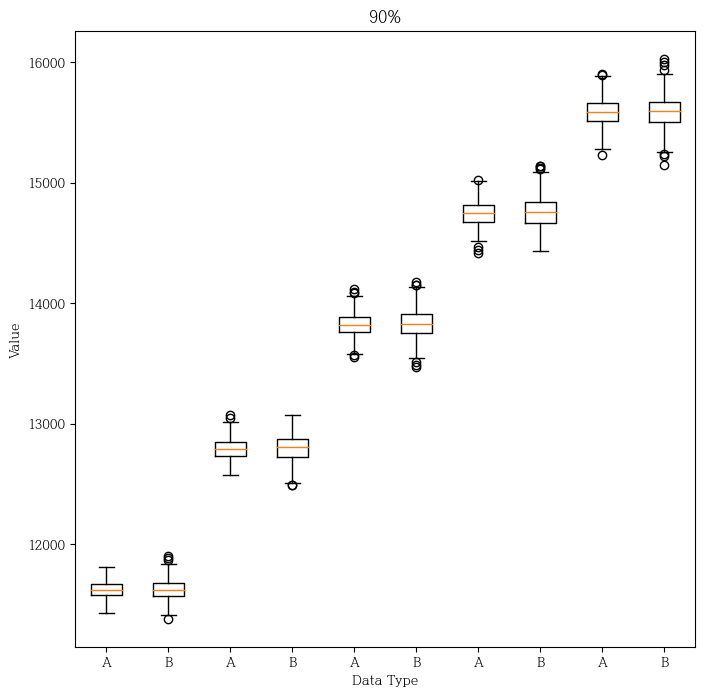

In [40]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '90%' , iteration = 500)

### 90% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

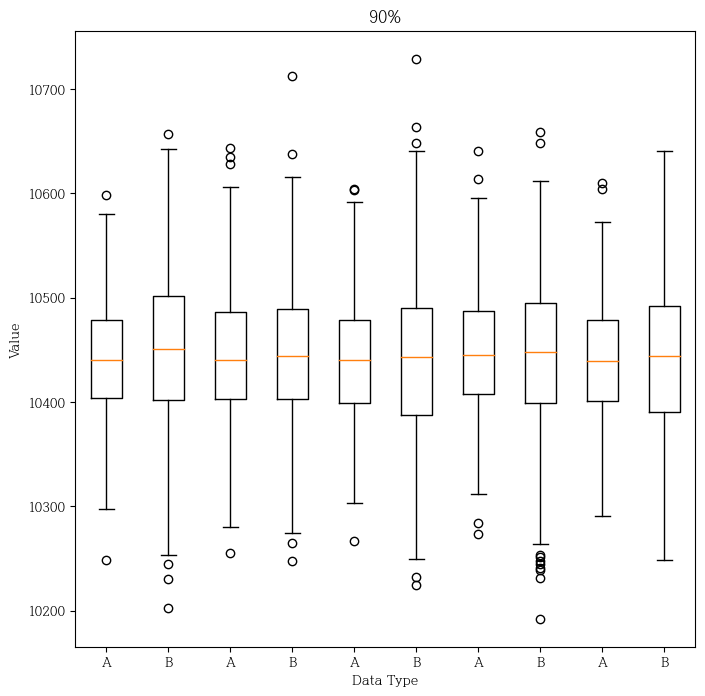

In [70]:
all_boxplot(variable = "경상소득(조사)" , statistic = '90%' , iteration = 500)

### 99% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

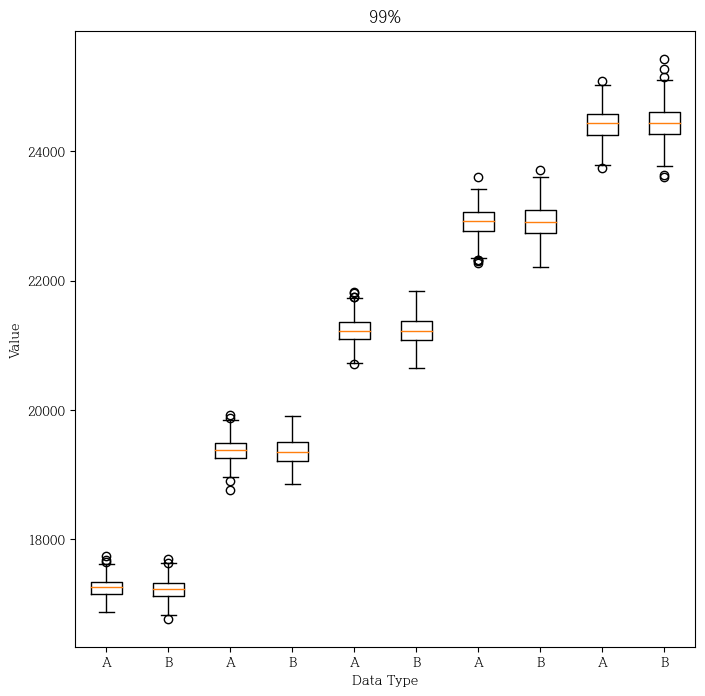

In [42]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '99%' , iteration = 500)

### 99% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

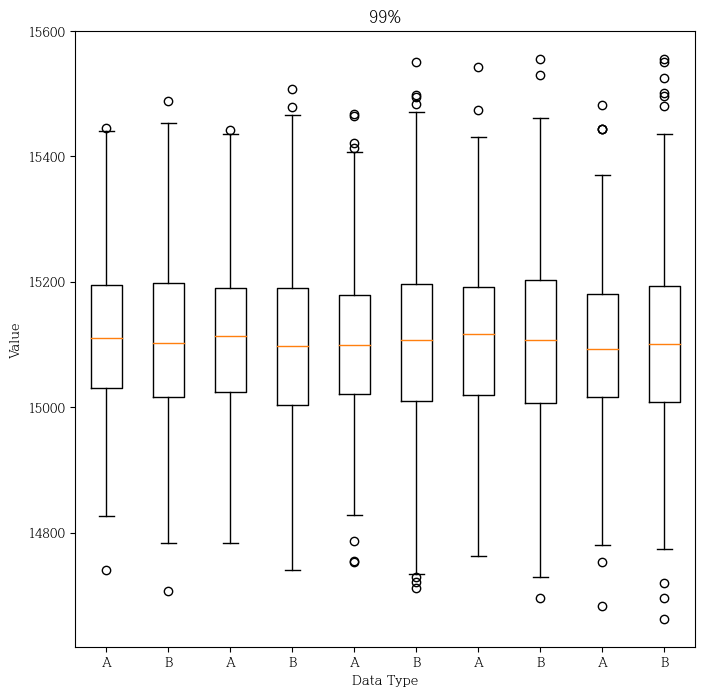

In [71]:
all_boxplot(variable = "경상소득(조사)" , statistic = '99%' , iteration = 500)

In [97]:
def non_all_scatter(variable, statistic, iteration):
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    for i in range(1, 6):
        original = eval(f'non_rho{i}_mvn')
        synthetic = eval(f'GC_non_rho{i}_data') 
        
        if statistic == 'mean':
            a = [np.mean(original[j][variable]) for j in range(iteration)]
            b = [np.mean(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == 'std':
            a = [np.std(original[j][variable]) for j in range(iteration)]
            b = [np.std(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == '25%':
            a = [np.quantile(original[j][variable] , q = .25) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable] , q = .25) for j in range(iteration)]
        elif statistic == '50%':
            a = [np.quantile(original[j][variable] , q = .50) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .50) for j in range(iteration)]
        elif statistic == '75%':
            a = [np.quantile(original[j][variable], q = .75) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .75) for j in range(iteration)]
        elif statistic == '90%':
            a = [np.quantile(original[j][variable], q = .90) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .90) for j in range(iteration)]
        elif statistic == '99%':
            a = [np.quantile(original[j][variable], q = .99) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .99) for j in range(iteration)]        
        else:
            raise ValueError("no invalid statistic")
        
    plt.scatter(a, b)    
    ax.set_xlabel('original')
    ax.set_ylabel('synthetic')
    plt.title(statistic.capitalize())  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

### 그래프 겹쳐그리기 경상소득(포함)에 대한 평균에 대한 그래프 -> 수정해서 일대일 대응으로 볼 수 있도록 수정

In [96]:
def two_scatter(variable1, variable2 , statistic, iteration):
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    for i in range(1, 6):
        original = eval(f'all_rho{i}_mvn')
        synthetic = eval(f'GC_all_rho{i}_data') 
        
        if statistic == 'mean':
            a = [np.mean(original[j][variable1]) for j in range(iteration)]
            b = [np.mean(synthetic[j][variable1]) for j in range(iteration)]
            c = [np.mean(original[j][variable2]) for j in range(iteration)]
            d = [np.mean(synthetic[j][variable2]) for j in range(iteration)]
            
        elif statistic == 'std':
            a = [np.std(original[j][variable1]) for j in range(iteration)]
            b = [np.std(synthetic[j][variable1]) for j in range(iteration)]
            c = [np.std(original[j][variable2]) for j in range(iteration)]
            d = [np.std(synthetic[j][variable2]) for j in range(iteration)]
            
        elif statistic == '25%':
            a = [np.quantile(original[j][variable1] , q = .25) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable1] , q = .25) for j in range(iteration)]
            c = [np.quantile(original[j][variable2] , q = .25) for j in range(iteration)]
            d = [np.quantile(synthetic[j][variable2] , q = .25) for j in range(iteration)]
            
        elif statistic == '50%':
            a = [np.quantile(original[j][variable1] , q = .50) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable1], q = .50) for j in range(iteration)]
            c = [np.quantile(original[j][variable2] , q = .50) for j in range(iteration)]
            d = [np.quantile(synthetic[j][variable2], q = .50) for j in range(iteration)]
            
        elif statistic == '75%':
            a = [np.quantile(original[j][variable1], q = .75) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable1], q = .75) for j in range(iteration)]
            c = [np.quantile(original[j][variable2], q = .75) for j in range(iteration)]
            d = [np.quantile(synthetic[j][variable2], q = .75) for j in range(iteration)]
            
        elif statistic == '90%':
            a = [np.quantile(original[j][variable1], q = .90) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable1], q = .90) for j in range(iteration)]
            c = [np.quantile(original[j][variable2], q = .90) for j in range(iteration)]
            d = [np.quantile(synthetic[j][variable2], q = .90) for j in range(iteration)]
            
        elif statistic == '99%':
            a = [np.quantile(original[j][variable1], q = .99) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable1], q = .99) for j in range(iteration)]
            c = [np.quantile(original[j][variable2], q = .99) for j in range(iteration)]
            d = [np.quantile(synthetic[j][variable2], q = .99) for j in range(iteration)]
            
        else:
            raise ValueError("no invalid statistic")
        
    plt.scatter(a, c, color = 'purple' , alpha = 0.7 , label = '원자료')
    plt.scatter(b, d, color = 'orange' , alpha = 0.1 , label = "재현자료")
    plt.legend()
    ax.set_xlabel('original')
    ax.set_ylabel('synthetic')
    plt.title(statistic.capitalize())  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

### 그래프 일대일로 겹처서 그리기 ( 첫번째 시뮬레이션 결과에 대해서 )

In [99]:
def one_by_scatter(data1 , data2 , variable1 , variable2):
        
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    plt.scatter(data1[variable1], data1[variable2] , color = 'purple' , alpha = 0.3 , label = '원자료')
    plt.scatter(data2[variable1], data2[variable2] , color = 'orange' , alpha = 0.1 , label = "재현자료")
    plt.legend()
    ax.set_xlabel(variable1)
    ax.set_ylabel(variable2)
    plt.title('plot')  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

### 경상소득이 포함되지 않은 자료에 대한 그래프

#### $\rho$ = 0.1

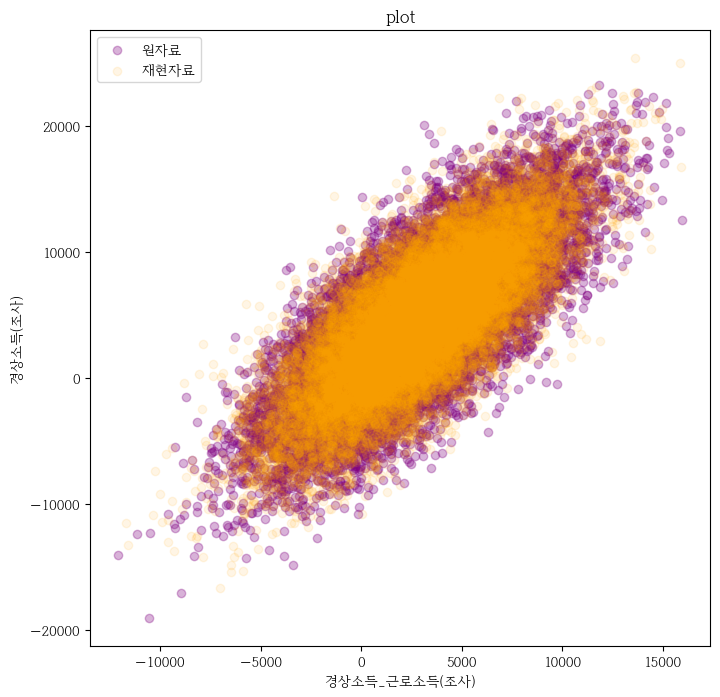

In [100]:
one_by_scatter(non_rho1_mvn[0] , GC_non_rho1_data[0] ,'경상소득_근로소득(조사)' ,  '경상소득(조사)' )

#### $\rho$ = 0.3

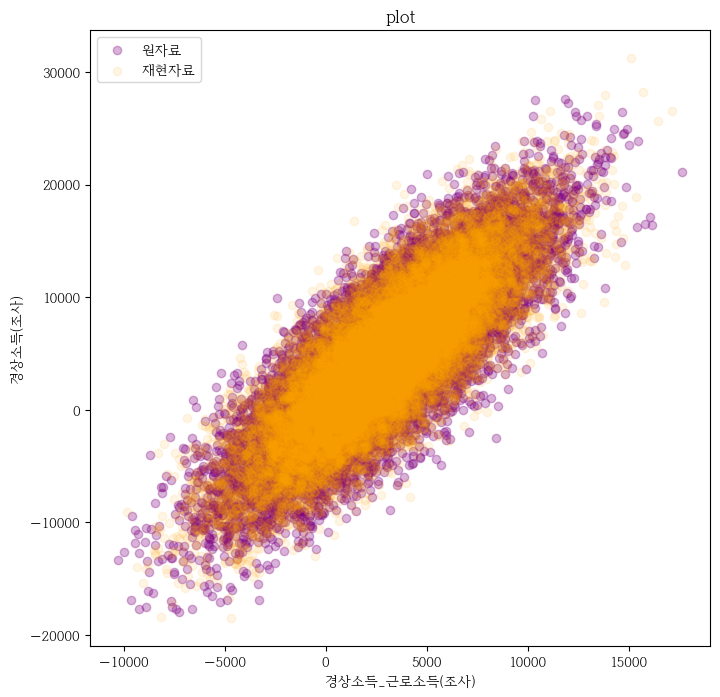

In [101]:
one_by_scatter(non_rho2_mvn[0] , GC_non_rho2_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.5

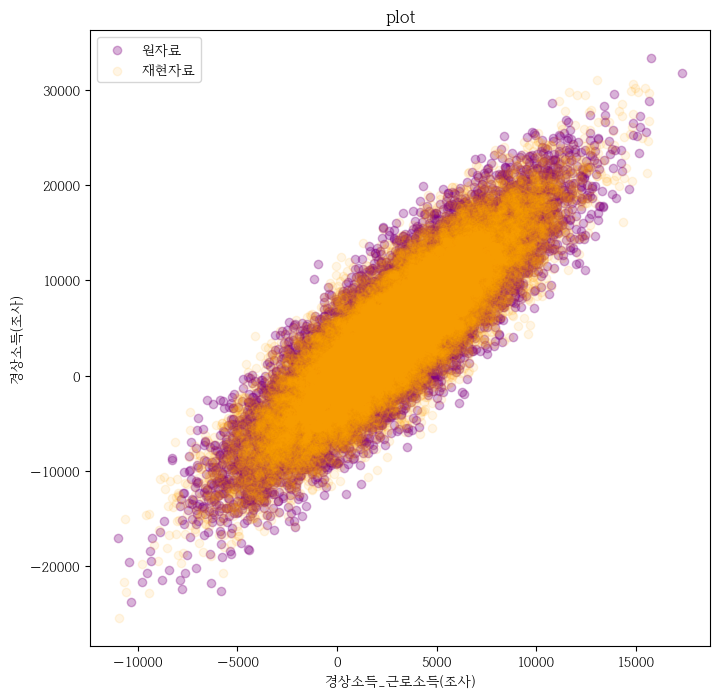

In [102]:
one_by_scatter(non_rho3_mvn[0] , GC_non_rho3_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.7

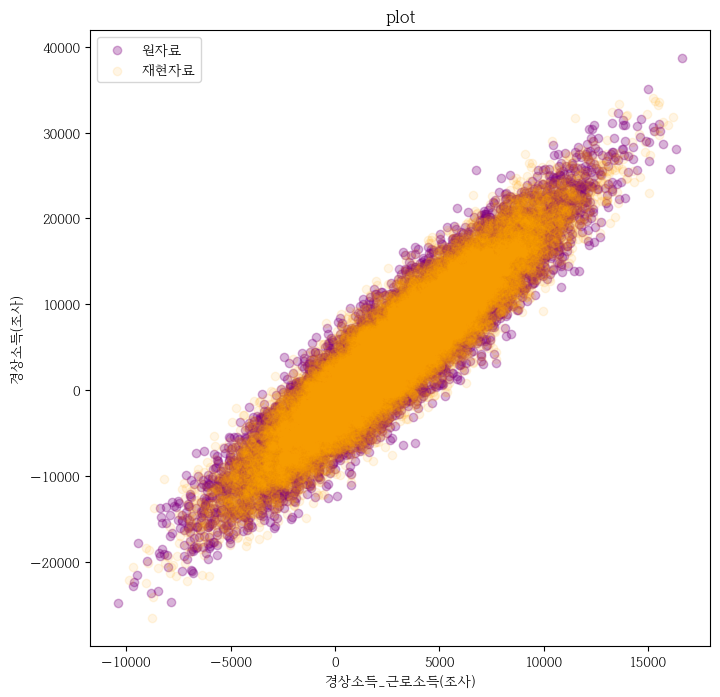

In [103]:
one_by_scatter(non_rho4_mvn[0] , GC_non_rho4_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.9

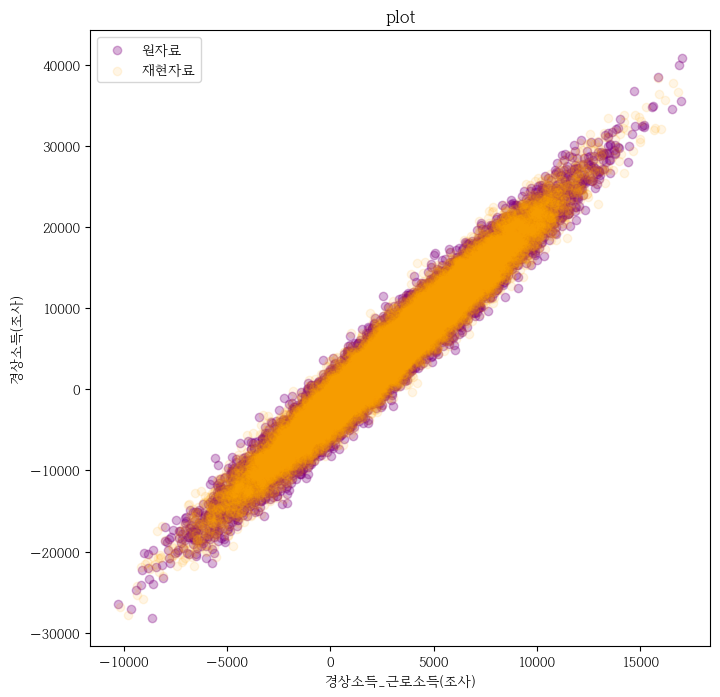

In [104]:
one_by_scatter(non_rho5_mvn[0] , GC_non_rho5_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

### 경상소득이 포함된 자료에 대한 그래프

#### $\rho$ = 0.1

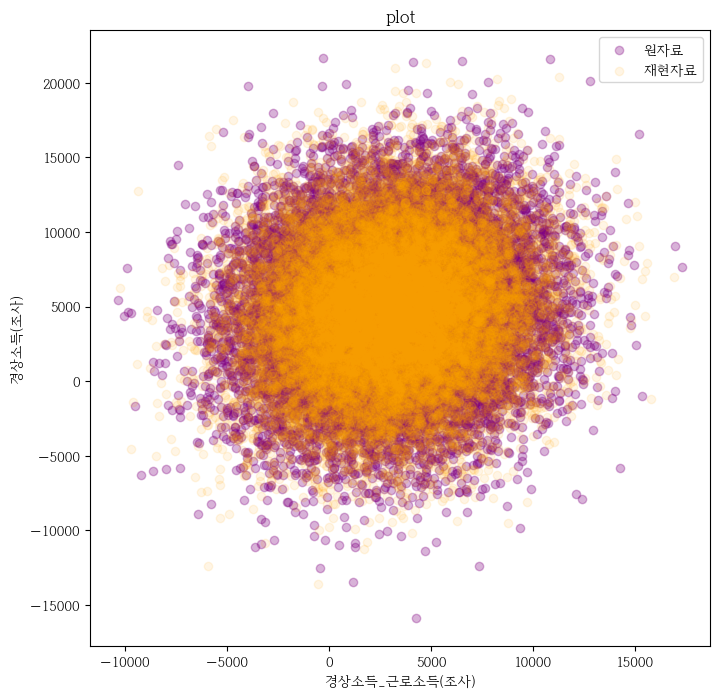

In [105]:
one_by_scatter(all_rho1_mvn[0] , GC_all_rho1_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.3

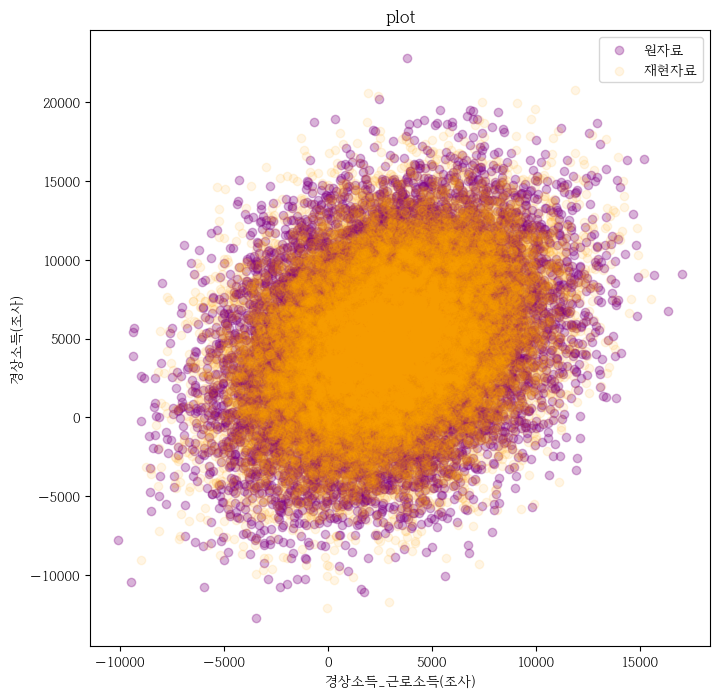

In [106]:
one_by_scatter(all_rho2_mvn[0] , GC_all_rho2_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.5

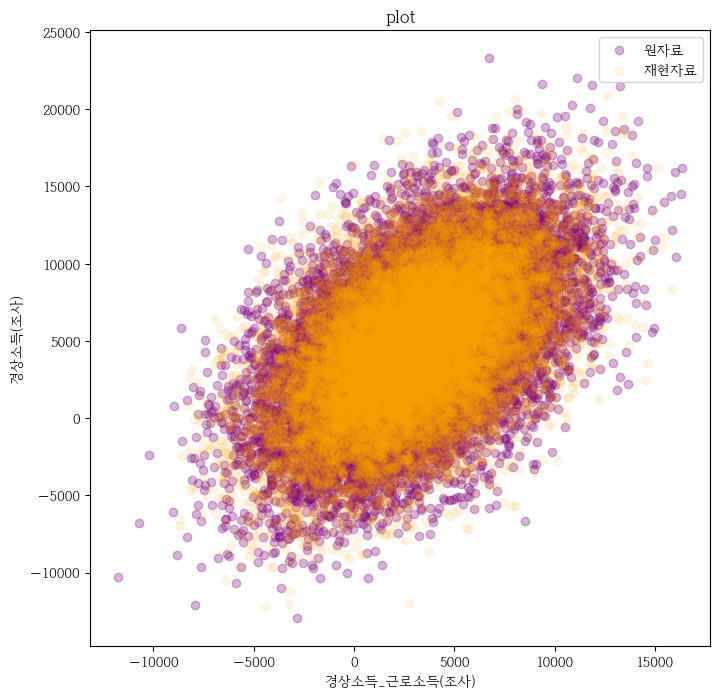

In [107]:
one_by_scatter(all_rho3_mvn[0] , GC_all_rho3_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.7

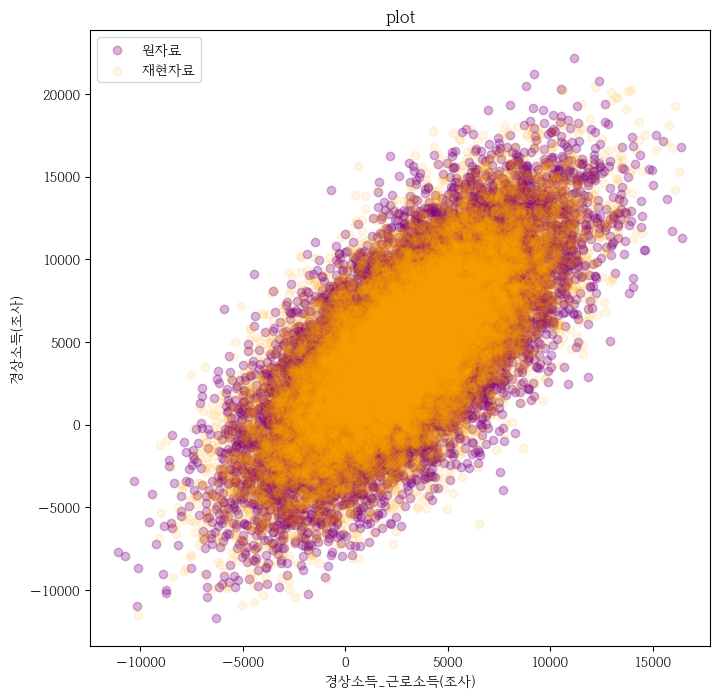

In [108]:
one_by_scatter(all_rho4_mvn[0] , GC_all_rho4_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.9

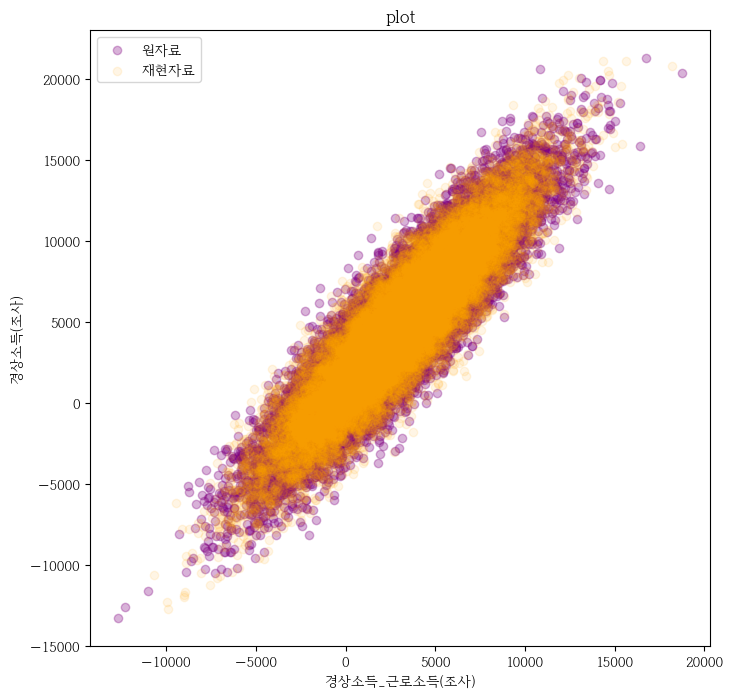

In [109]:
one_by_scatter(all_rho5_mvn[0] , GC_all_rho5_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

### 경상소득이 포함되지 않은 자료에 대한 상관계수 그래프 

두개 같이 그렸을때 히트맵 크기가 일정하게 고정되서 나오지 않음 , 수정 필수

#### $\rho$ = 0.1

Text(0.5, 1.0, '전체재현자료')

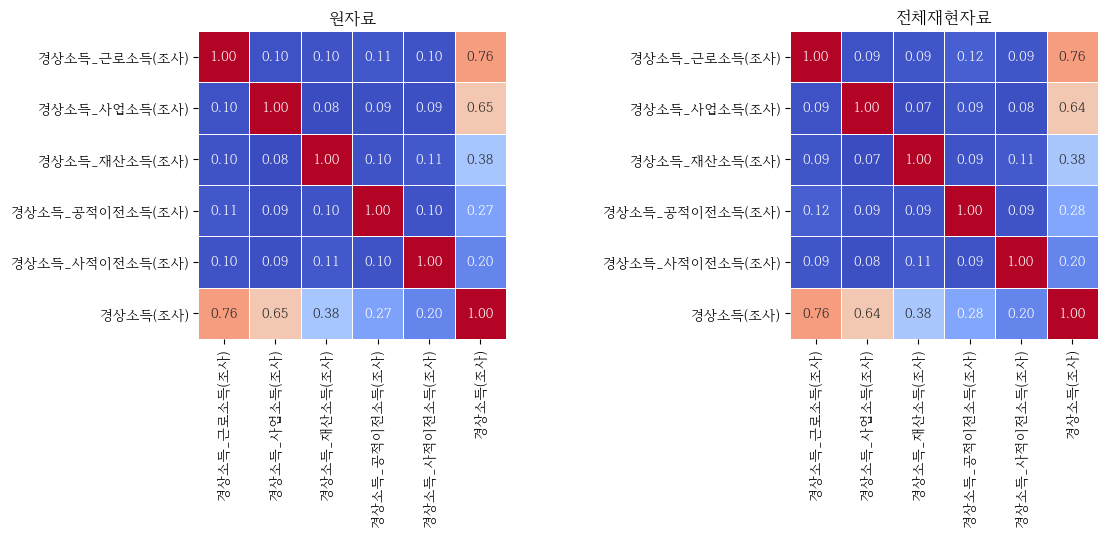

In [99]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14 ,5)
sns.heatmap(non_rho1_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False) 
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_non_rho1_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.3

Text(0.5, 1.0, '전체재현자료')

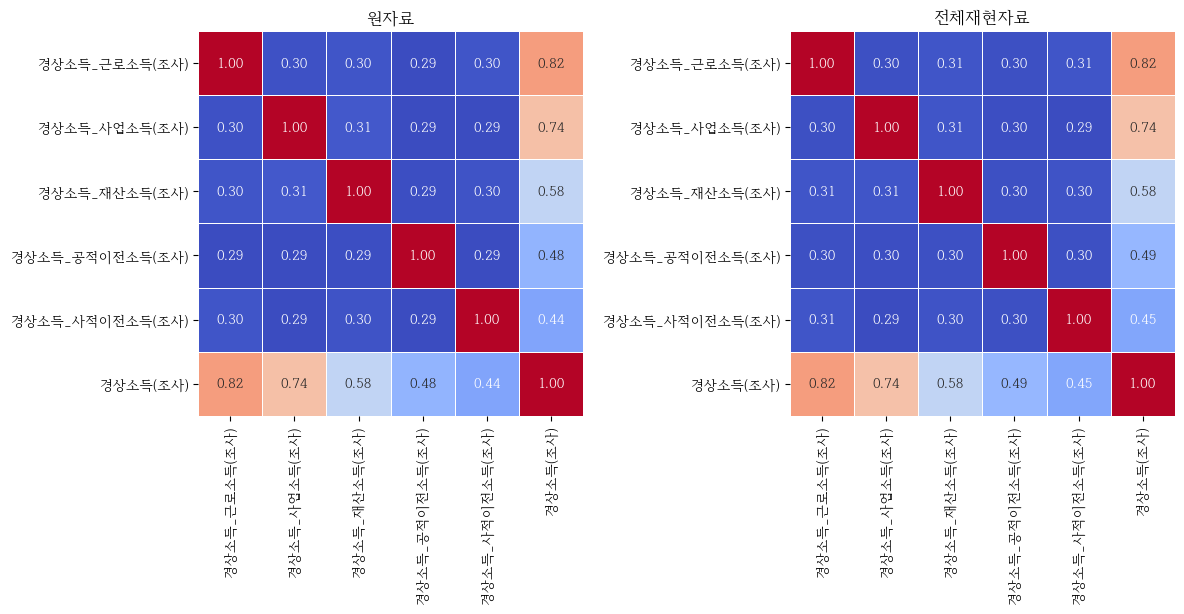

In [101]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho2_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_non_rho2_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.5

Text(0.5, 1.0, '전체재현자료')

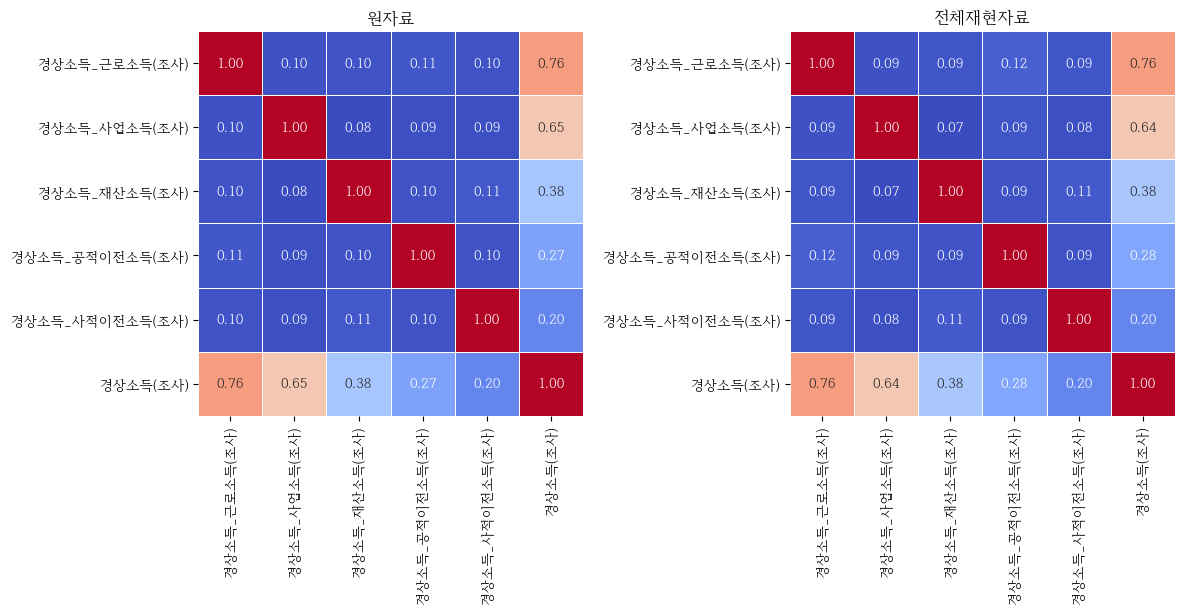

In [103]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho1_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_non_rho1_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.7

Text(0.5, 1.0, '전체재현자료')

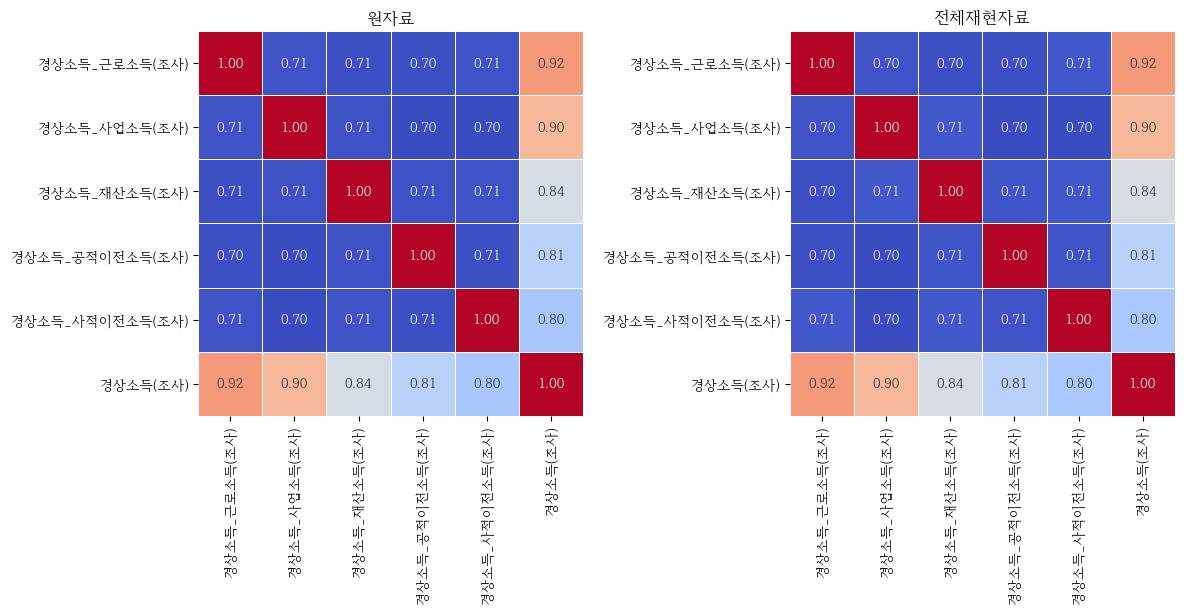

In [104]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho4_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar= False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_non_rho4_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.9

Text(0.5, 1.0, '전체재현자료')

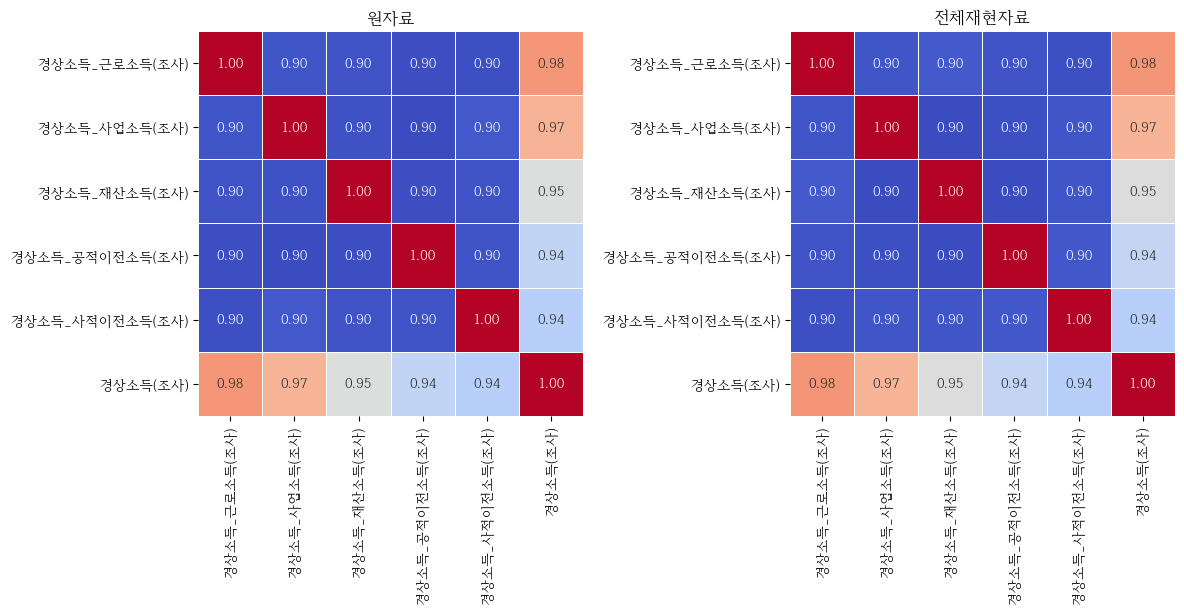

In [107]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho5_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_non_rho5_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

### 경상소득이 포함된 자료에 대한 상관계수 그래프

#### $\rho$ = 0.1

Text(0.5, 1.0, '전체재현자료')

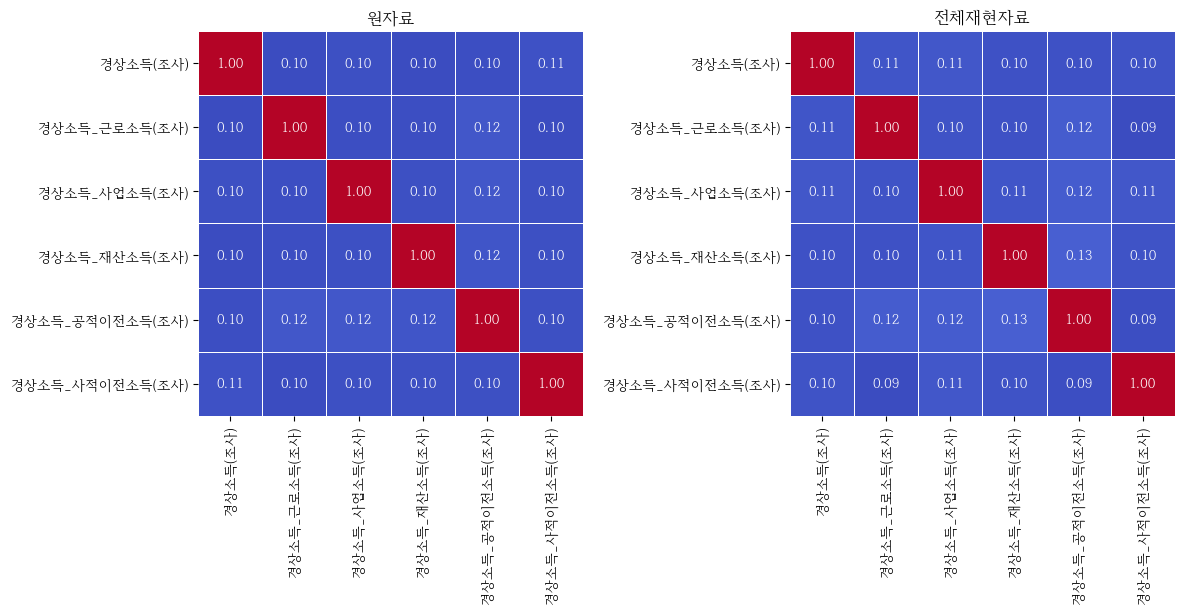

In [110]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14 , 5)
sns.heatmap(all_rho1_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_all_rho1_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.3

Text(0.5, 1.0, '전체재현자료')

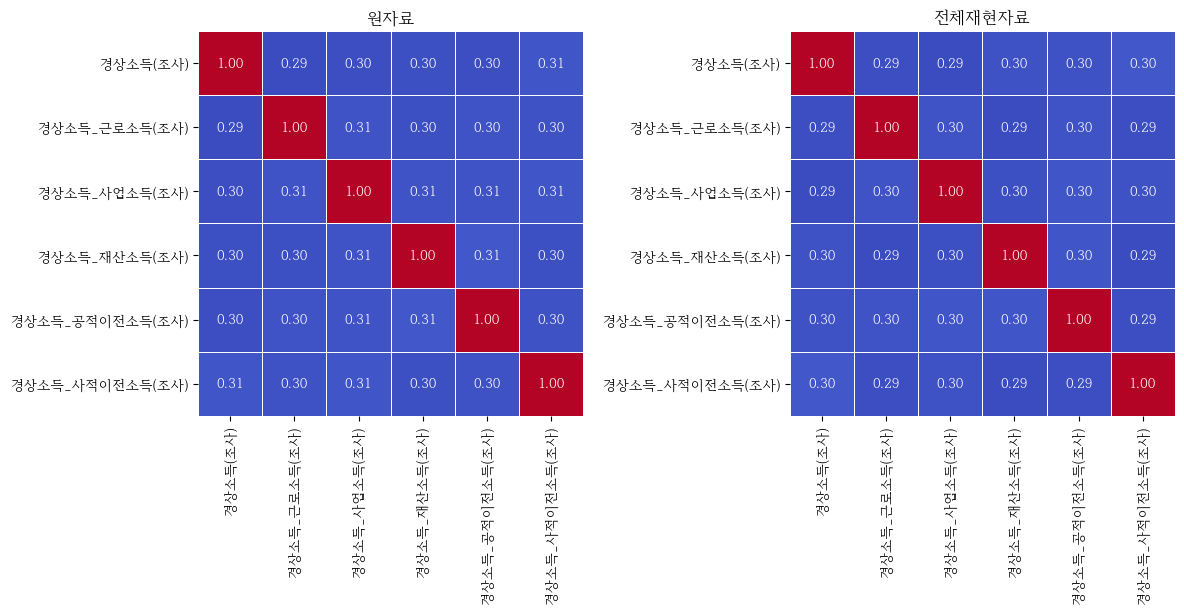

In [111]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho2_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_all_rho2_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True ,cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.5

Text(0.5, 1.0, '전체재현자료')

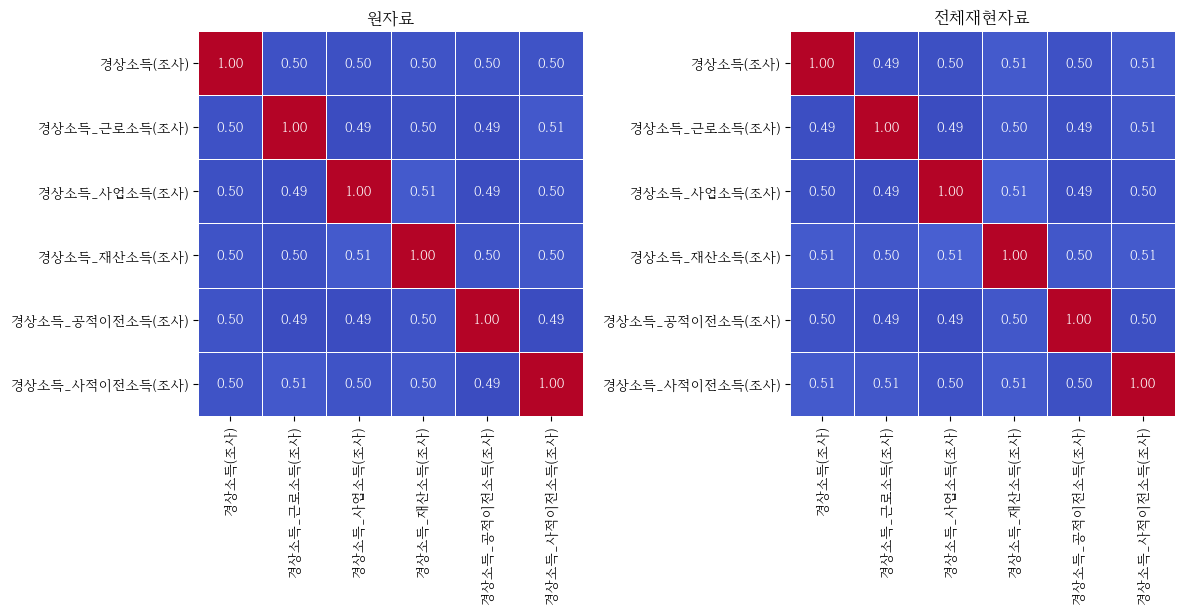

In [114]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho3_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_all_rho3_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.7

Text(0.5, 1.0, '전체재현자료')

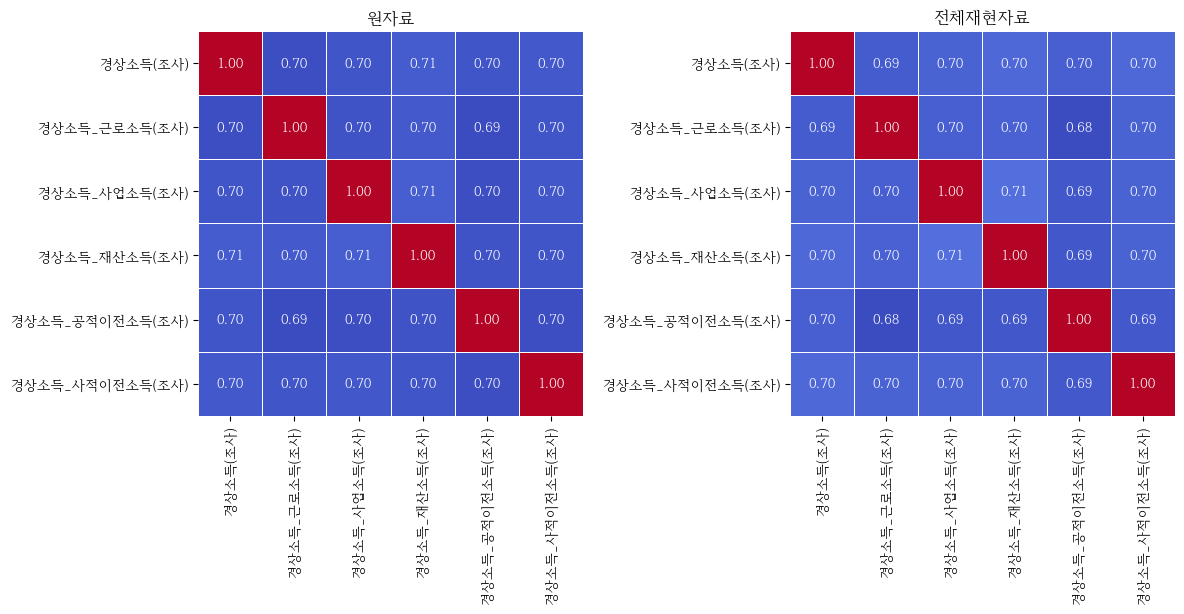

In [115]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho4_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_all_rho4_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.9

Text(0.5, 1.0, '전체재현자료')

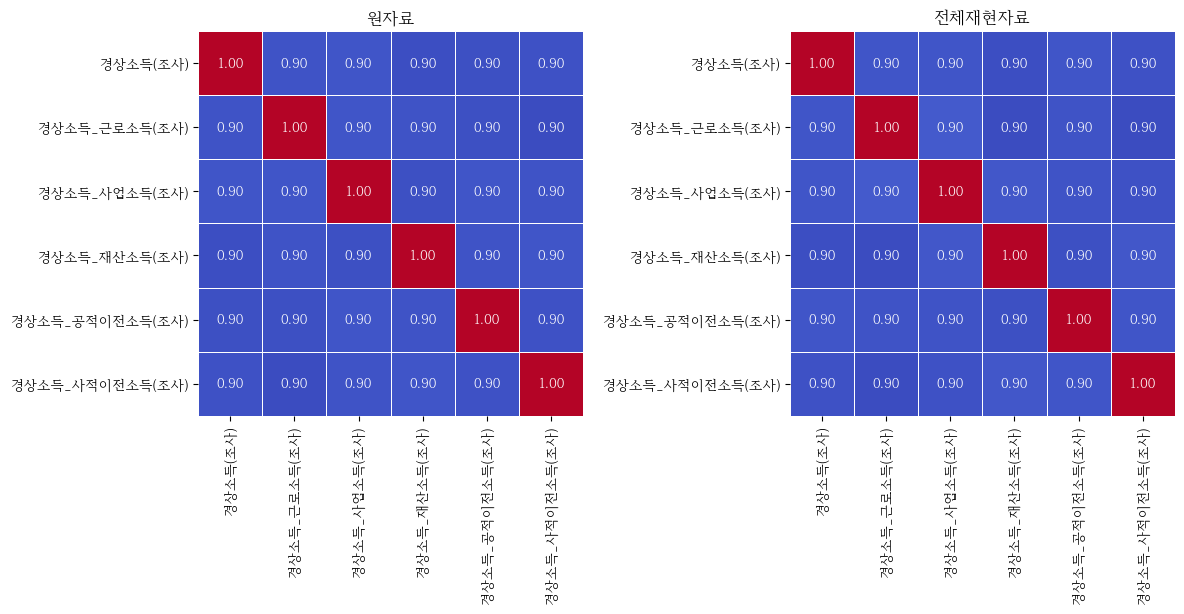

In [76]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho5_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(GC_all_rho5_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

## KSComplement ( 원자료 , 재현자료 , 변수 , 반복횟수 ) - 실제자료와 재현자료간의 유사성 측정

In [77]:
def KSComplements(oridata , synthetic_data , variable , iteration) : 
    
    KSComplement_Result = []       

    for i in range(iteration) : 
        KSComplement_Result.append(
            KSComplement.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return KSComplement_Result 

In [121]:
KS1 = KSComplements(non_rho1_mvn , GC_non_rho1_data , '경상소득(조사)' , 500)
KS2 = KSComplements(non_rho2_mvn , GC_non_rho2_data , '경상소득(조사)' , 500)
KS3 = KSComplements(non_rho3_mvn , GC_non_rho3_data , '경상소득(조사)' , 500)
KS4 = KSComplements(non_rho4_mvn , GC_non_rho4_data , '경상소득(조사)' , 500)
KS5 = KSComplements(non_rho5_mvn , GC_non_rho5_data , '경상소득(조사)' , 500)

In [78]:
AKS1 = KSComplements(all_rho1_mvn , GC_all_rho1_data , '경상소득(조사)' , 500)
AKS2 = KSComplements(all_rho2_mvn , GC_all_rho2_data , '경상소득(조사)' , 500)
AKS3 = KSComplements(all_rho3_mvn , GC_all_rho3_data , '경상소득(조사)' , 500)
AKS4 = KSComplements(all_rho4_mvn , GC_all_rho4_data , '경상소득(조사)' , 500)
AKS5 = KSComplements(all_rho5_mvn , GC_all_rho5_data , '경상소득(조사)' , 500)

In [79]:
def calculate_statistics(data):
    results = {
        'mean': np.array(np.mean(data)),
        'std': np.array(np.std(data))}
    return results

In [80]:
def measure_dataframe(data1 , data2 , data3 , data4 ,data5):
    
    result = np.array([[np.mean(data1) , np.std(data1)] , [np.mean(data2) , np.std(data2)] , [np.mean(data3) , np.std(data3)] , [np.mean(data4) , np.std(data4)] , [np.mean(data5) , np.std(data5)]])
    frame = pd.DataFrame(result)
    frame.columns = ["척도의 평균" , "척도의 표준편차"]
    frame.index = ['0.1','0.3','0.5','0.7','0.9']
    
    return pd.DataFrame(frame )


경상소득(조사) 미포함

In [125]:
measure_dataframe(KS1 , KS2 , KS3 , KS4 , KS5)

척도의 평균  척도의 표준편차
0.1  0.991843  0.002118
0.3  0.991774  0.002243
0.5  0.991896  0.002182
0.7  0.991984  0.002186
0.9  0.991845  0.002262

경상소득(조사) 포함

In [81]:
measure_dataframe(AKS1 , AKS2 , AKS3 , AKS4 , AKS5)

척도의 평균  척도의 표준편차
0.1  0.991976  0.002246
0.3  0.991961  0.002154
0.5  0.991903  0.002267
0.7  0.991811  0.002175
0.9  0.991879  0.002096

### CorrelationSimilarity ( 원자료 , 재현자료 , 변수1 , 변수2 , 피어슨 OR 스피어만 , 반복횟수 ) - 상관관계 측정 및 유사성 계산

In [82]:
def CorrelationSimilaritys(oridata , synthetic_data , variable1 , variable2 , method , iteration) : 
    
    CorrelationSimilarity_Result = [] 

    for i in range(iteration) : 
        CorrelationSimilarity_Result.append(
            CorrelationSimilarity.compute(
                real_data = oridata[i][[variable1 , variable2]],
                synthetic_data = synthetic_data[i][[variable1 , variable2]],
                coefficient = method))
        
    return CorrelationSimilarity_Result 

In [128]:
CS1 = CorrelationSimilaritys(non_rho1_mvn , GC_non_rho1_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS2 = CorrelationSimilaritys(non_rho2_mvn , GC_non_rho2_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS3 = CorrelationSimilaritys(non_rho3_mvn , GC_non_rho3_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS4 = CorrelationSimilaritys(non_rho4_mvn , GC_non_rho4_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS5 = CorrelationSimilaritys(non_rho5_mvn , GC_non_rho5_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)

In [83]:
ACS1 = CorrelationSimilaritys(all_rho1_mvn , GC_all_rho1_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS2 = CorrelationSimilaritys(all_rho2_mvn , GC_all_rho2_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS3 = CorrelationSimilaritys(all_rho3_mvn , GC_all_rho3_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS4 = CorrelationSimilaritys(all_rho4_mvn , GC_all_rho4_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS5 = CorrelationSimilaritys(all_rho5_mvn , GC_all_rho5_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)

경상소득(조사) 미포함

In [130]:
measure_dataframe(CS1 , CS2 , CS3 , CS4 , CS5)

척도의 평균  척도의 표준편차
0.1  0.996932  0.002350
0.3  0.997393  0.001949
0.5  0.997772  0.001719
0.7  0.998530  0.001111
0.9  0.999401  0.000450

경상소득(조사) 포함

In [84]:
measure_dataframe(ACS1 , ACS2 , ACS3 , ACS4 , ACS5)

척도의 평균  척도의 표준편차
0.1  0.996902  0.002258
0.3  0.997223  0.002078
0.5  0.997832  0.001680
0.7  0.998453  0.001166
0.9  0.999465  0.000434

### RangeCoverage ( 원자료 , 재현자료 , 변수 , 반복횟수 ) - 재현자료의 열이 실제 데이터의 열의 모든범위의 값을 포함하는지 여부

In [85]:
def RangeCoverages(oridata , synthetic_data , variable , iteration) : 
    
    RangeCoverage_Result = [] 
    
    for i in range(iteration) :
        RangeCoverage_Result.append(
            RangeCoverage.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return RangeCoverage_Result
    

In [139]:
RC1 = RangeCoverages(non_rho1_mvn , GC_non_rho1_data , '경상소득(조사)' , 500)
RC2 = RangeCoverages(non_rho2_mvn , GC_non_rho2_data , '경상소득(조사)' , 500)
RC3 = RangeCoverages(non_rho3_mvn , GC_non_rho3_data , '경상소득(조사)' , 500)
RC4 = RangeCoverages(non_rho4_mvn , GC_non_rho4_data , '경상소득(조사)' , 500)
RC5 = RangeCoverages(non_rho5_mvn , GC_non_rho5_data , '경상소득(조사)' , 500)

In [86]:
ARC1 = RangeCoverages(all_rho1_mvn , GC_all_rho1_data , '경상소득(조사)' , 500)
ARC2 = RangeCoverages(all_rho2_mvn , GC_all_rho2_data , '경상소득(조사)' , 500)
ARC3 = RangeCoverages(all_rho3_mvn , GC_all_rho3_data , '경상소득(조사)' , 500)
ARC4 = RangeCoverages(all_rho4_mvn , GC_all_rho4_data , '경상소득(조사)' , 500)
ARC5 = RangeCoverages(all_rho5_mvn , GC_all_rho5_data , '경상소득(조사)' , 500)

경상소득(조사) 미포함

In [141]:
measure_dataframe(RC1 , RC2 , RC3 , RC4 , RC5)

척도의 평균  척도의 표준편차
0.1  0.956643  0.042624
0.3  0.956875  0.038964
0.5  0.950682  0.041154
0.7  0.949339  0.041540
0.9  0.942883  0.042307

경상소득(조사) 포함

In [87]:
measure_dataframe(ARC1 , ARC2 , ARC3 , ARC4 , ARC5)

척도의 평균  척도의 표준편차
0.1  0.942965  0.035145
0.3  0.939701  0.038602
0.5  0.940556  0.039470
0.7  0.942832  0.036942
0.9  0.942493  0.036762

### BoundaryAdherence ( 원자료 , 재현자료 , 변수 , 반복횟수) - 재현자료가 실제자료의 최소값과 최대값을 준수하는지 여부를 결정

In [88]:
def BoundaryAdherences(oridata , synthetic_data , variable , iteration): 
    
    BoundaryAdherence_Result = []
    
    for i in range(iteration) : 
        BoundaryAdherence_Result.append(
            BoundaryAdherence.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return BoundaryAdherence_Result

In [144]:
BA1 = BoundaryAdherences(non_rho1_mvn , GC_non_rho1_data , '경상소득(조사)' , 500)
BA2 = BoundaryAdherences(non_rho2_mvn , GC_non_rho2_data , '경상소득(조사)' , 500)
BA3 = BoundaryAdherences(non_rho3_mvn , GC_non_rho3_data , '경상소득(조사)' , 500)
BA4 = BoundaryAdherences(non_rho4_mvn , GC_non_rho4_data , '경상소득(조사)' , 500)
BA5 = BoundaryAdherences(non_rho5_mvn , GC_non_rho5_data , '경상소득(조사)' , 500)

In [89]:
ABA1 = BoundaryAdherences(all_rho1_mvn , GC_all_rho1_data , '경상소득(조사)' , 500)
ABA2 = BoundaryAdherences(all_rho2_mvn , GC_all_rho2_data , '경상소득(조사)' , 500)
ABA3 = BoundaryAdherences(all_rho3_mvn , GC_all_rho3_data , '경상소득(조사)' , 500)
ABA4 = BoundaryAdherences(all_rho4_mvn , GC_all_rho4_data , '경상소득(조사)' , 500)
ABA5 = BoundaryAdherences(all_rho5_mvn , GC_all_rho5_data , '경상소득(조사)' , 500)

경상소득(조사) 미포함

In [146]:
measure_dataframe(BA1 , BA2 , BA3 , BA4 , BA5)

척도의 평균  척도의 표준편차
0.1  0.999905  0.000099
0.3  0.999913  0.000097
0.5  0.999923  0.000089
0.7  0.999931  0.000076
0.9  0.999960  0.000064

경상소득(조사) 포함

In [90]:
measure_dataframe(ABA1 , ABA2 , ABA3 , ABA4 , ABA5)

척도의 평균  척도의 표준편차
0.1     1.0       0.0
0.3     1.0       0.0
0.5     1.0       0.0
0.7     1.0       0.0
0.9     1.0       0.0

### KL DIVERGENCE ( 원자료 , 재현자료 , 변수 , 반복횟수 ) 

In [91]:
"""ColumnPair metrics based on Kullback–Leibler Divergence."""

import numpy as np
import pandas as pd
from scipy.special import kl_div

from sdmetrics.column_pairs.base import ColumnPairsMetric
from sdmetrics.goal import Goal
from sdmetrics.utils import get_frequencies


class ContinuousKLDivergence(ColumnPairsMetric):
    """Continuous Kullback–Leibler Divergence based metric.

    This approximates the KL divergence by binning the continuous values
    to turn them into categorical values and then computing the relative
    entropy. Afterwards normalizes the value applying ``1 / (1 + KLD)``.

    Attributes:
        name (str):
            Name to use when reports about this metric are printed.
        goal (sdmetrics.goal.Goal):
            The goal of this metric.
        min_value (Union[float, tuple[float]]):
            Minimum value or values that this metric can take.
        max_value (Union[float, tuple[float]]):
            Maximum value or values that this metric can take.
    """

    name = 'Continuous Kullback–Leibler Divergence'
    goal = Goal.MAXIMIZE
    min_value = 0.0
    max_value = 1.0

    @staticmethod
    def compute(real_data, synthetic_data):
        """Compare two pairs of continuous columns using Kullback–Leibler Divergence.

        Args:
            real_data (pandas.DataFrame):
                The values from the real dataset, passed as pandas.DataFrame
                with 2 columns.
            synthetic_data (pandas.DataFrame):
                The values from the synthetic dataset, passed as a
                pandas.DataFrame with 2 columns.

        Returns:
            Union[float, tuple[float]]:
                Metric output.
        """
        real_data[pd.isna(real_data)] = 0.0
        synthetic_data[pd.isna(synthetic_data)] = 0.0
        column1 = '경상소득_근로소득(조사)'
        column2 = '경상소득(조사)'
        
        real, xedges, yedges = np.histogram2d(real_data[column1], real_data[column2])
        synthetic, _, _ = np.histogram2d(
            synthetic_data[column1], synthetic_data[column2], bins=[xedges, yedges])

        f_obs, f_exp = synthetic.flatten() + 1e-5, real.flatten() + 1e-5
        f_obs, f_exp = f_obs / np.sum(f_obs), f_exp / np.sum(f_exp)

        return 1 / (1 + np.sum(kl_div(f_obs, f_exp)))

    @classmethod
    def normalize(cls, raw_score):
        """Return the `raw_score` as is, since it is already normalized.

        Args:
            raw_score (float):
                The value of the metric from `compute`.

        Returns:
            float:
                The normalized value of the metric
        """
        return super().normalize(raw_score)

In [92]:
continous_k1_metric = ContinuousKLDivergence()

In [93]:
def KLD(oridata, synthetic_data , iteration) : # 이용 변수 : 경상소득(조사) , 경상소득_근로소득(조사)
    
    KLD_Result = [] 
    
    for i in range(iteration) : 
        KLD_Result.append(
            continous_k1_metric.compute(oridata[i] , synthetic_data[i]))
    
    return KLD_Result

In [25]:
KL1 = KLD(non_rho1_mvn ,  GC_non_rho1_data , 500)
KL2 = KLD(non_rho2_mvn ,  GC_non_rho2_data , 500)
KL3 = KLD(non_rho3_mvn ,  GC_non_rho3_data , 500)
KL4 = KLD(non_rho4_mvn ,  GC_non_rho4_data , 500)
KL5 = KLD(non_rho5_mvn ,  GC_non_rho5_data , 500)

In [94]:
AKL1 = KLD(all_rho1_mvn , GC_all_rho1_data , 500)
AKL2 = KLD(all_rho2_mvn , GC_all_rho2_data , 500)
AKL3 = KLD(all_rho3_mvn , GC_all_rho3_data , 500)
AKL4 = KLD(all_rho4_mvn , GC_all_rho4_data , 500)
AKL5 = KLD(all_rho5_mvn , GC_all_rho5_data , 500)

경상소득(조사) 미포함

In [31]:
measure_dataframe(KL1 , KL2 , KL3 , KL4 , KL5)

척도의 평균  척도의 표준편차
0.1  0.994696  0.001768
0.3  0.995206  0.001644
0.5  0.995614  0.001612
0.7  0.996487  0.001512
0.9  0.997565  0.001195

경상소득(조사) 포함

In [95]:
measure_dataframe(AKL1 , AKL2 , AKL3 , AKL4 , AKL5)

척도의 평균  척도의 표준편차
0.1  0.991686  0.002279
0.3  0.991886  0.002443
0.5  0.992846  0.002120
0.7  0.994019  0.001941
0.9  0.995956  0.001453

## CAP algorithm

In [174]:
from sdmetrics.single_table import CategoricalCAP

score = CategoricalCAP.compute(
    real_data = non_rho1_mvn[1],
    synthetic_data = GC_non_rho1_data[1],
    key_fields=['경상소득_근로소득(조사)', '경상소득_사업소득(조사)'],
    sensitive_fields=['경상소득(조사)']
)

In [175]:
score

0